# Condition survey datasets

This script loads and conditions the survey datasets into a single final dataframe containing the columns for the investigation

Conditioning is performed by transforming column names and categorical data to standard values, using extensive use of pandas map function

Dummy variables / one-hot-encoding is used for multiselect categorical options

Name selection was conducted manually as the process requires domain knowledge and some personal judgement.

- Value names: the completed map dict is stored in map_values.py. The dict tempate was generated using prep_label_standardisation()
- Column names: stored in csv files in the schemas folder Templates were generated with gen_schemas.py

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from routines import xzsave, load, prep_label_standardisation

pd.set_option('display.max_columns', None)

Define columns of interest, selected after an preliminary analysis of the questions across surveys

In [2]:
interest_cols = [
    'salary',
    'satisfaction',
    'age',
    'gender',
    'years_coding',
    'occupation',
    'employment',
    'industry',
    'org_size',
    'job_seek',
    'remote',
    'education',
    'undergrad',
    'os',
    'lang',  # programming languages used
    # 'country',  # deal with country later
]

load the survey data in to a list, using the load function in routines.py

In [3]:
surveys = [
    load(2011, "2011 Stack Overflow Survey Results.csv", 2),
    load(2012, "2012 Stack Overflow Survey Results.csv", 2),
    load(2013, "2013 Stack Overflow Survey Responses.csv", 2),
    load(2014, "2014 Stack Overflow Survey Responses.csv", 2),
    load(2015, "2015 Stack Overflow Developer Survey Responses.csv", 2),
    load(2016, "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv", 1),
    load(2017, "developer_survey_2017/survey_results_public.csv", 1),
    load(2018, "developer_survey_2018/survey_results_public.csv", 1),
    load(2019, "developer_survey_2019/survey_results_public.csv", 1),
    load(2020, "developer_survey_2020/survey_results_public.csv", 1),
]

2011 respondants: 2813, columns: 66
2012 respondants: 6243, columns: 76
2013 respondants: 9742, columns: 129
2014 respondants: 7643, columns: 121
2015 respondants: 26086, columns: 223
2016 respondants: 56030, columns: 65
2017 respondants: 51392, columns: 155
2018 respondants: 98855, columns: 130
2019 respondants: 88883, columns: 86
2020 respondants: 64461, columns: 62


We can see how both the number of respondents and amount of columns (tracking with number of questions) varies quite a bit across the years. In particular it is clear that the survey increased dramatically in 2015 and peaked in 2018.

Now, lets programatically identify which years contain the column of interest defined above

In [4]:
ft = pd.DataFrame(columns=interest_cols, index=range(2011, 2021))
for s, y in zip(surveys, range(2011, 2021)):
    ft.loc[y] = ft.columns.map(lambda x: x in s.columns)

ft.T

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
salary,True,True,True,True,True,True,True,True,True,True
satisfaction,True,True,True,False,True,True,True,True,True,True
age,True,True,True,True,True,True,False,True,True,True
gender,False,False,False,True,True,True,True,True,True,True
years_coding,True,True,True,True,True,True,True,True,True,True
occupation,True,True,True,True,True,True,True,True,True,True
employment,False,False,False,False,True,True,True,True,True,True
industry,True,True,True,True,True,True,True,False,False,False
org_size,True,True,True,False,False,True,True,True,True,True
job_seek,False,False,False,True,True,True,True,True,True,True


As we can see, there isn't a lot of consistency between the datasets. However, each question is present for at least 5 years.

at this point the value mapping dict template can be created using a separate function


In [ ]:
prep_label_standardisation(surveys, interest_cols, split=';')

This function identifies unique values, making it easy to study at nature of the questions and answers.

Ranged questions like salary and age were converted to median values. This may be an issue for the salary question in particular as the upper limit increased overtime.

For some questions it seems like the software used became confused and tried to convert the values to a date (years_coding in particular)

The finished dict was saved in map_values.py

In [5]:
from map_values import value_map

## standardise dummy variables

The 2011 - 2015 csv files use dummy columns for multiselect questions, which are transformed to boolean

The column names for these years have already been necesssarily transformed as the original columns were the question text

In [6]:
split_2011 = [
    "lang",
]

for df in surveys[:4]:
    for col in split_2011:
        c = df.columns.map(lambda x: x.startswith(col+'_'))
        df.loc[:, c] = df.loc[:, c].fillna(0)
        df.loc[:, c] = df.loc[:, c].ne(0).mul(1)

from 2016, certain columns became multicategorical stored as strings separated by ";"

We will also standardise the column names in the process. This is a bit tricky
1. split string into a list, transform items and remove duplicates
2. return to a string so pandas can work it's magic (str.get_dummies) to account for the variable lengths

In [7]:
split_2016 = [
    "occupation",
    "education",
    "lang",
]


def map_vals_list(x, col):
    try:
        return ';'.join(set([value_map[col][xi] for xi in x]))
    except TypeError:
        return x


for i, df in enumerate(surveys[4:]):
    print(pd.unique(df['survey_year']))
    new_cols = [df]
    for col in split_2016:
        if col in df:
            a = df.pop(col)
            a = a.str.split(r'\s*;\s*')
            a = a.map(lambda x: map_vals_list(x, col))
            a = a.str.get_dummies(';')
            a = a.rename(columns=lambda x : f'{col}_{x}')
            new_cols.append(a)
    surveys[i+4] = pd.concat(new_cols, axis=1)

[2015]
[2016]
[2017]
[2018]
[2019]
[2020]


## General transformation of variable data using the value map

From 2016, gender selection is multiselect, resulting in a wide range of options

In [10]:
unique = []
for df in surveys:
    if "gender" in df and df["gender"].dtype == object:
        unique.extend(list(pd.unique(df["gender"].dropna())))
sorted(list(set(unique)))

['Female',
 'Female; Gender non-conforming',
 'Female; Gender non-conforming; Other',
 'Female; Other',
 'Female; Transgender',
 'Female; Transgender; Gender non-conforming',
 'Female; Transgender; Gender non-conforming; Other',
 'Female; Transgender; Other',
 'Female;Male',
 'Female;Male;Non-binary, genderqueer, or gender non-conforming',
 'Female;Male;Transgender',
 'Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming',
 'Female;Non-binary, genderqueer, or gender non-conforming',
 'Female;Transgender',
 'Female;Transgender;Non-binary, genderqueer, or gender non-conforming',
 'Gender non-conforming',
 'Gender non-conforming; Other',
 'Male',
 'Male; Female',
 'Male; Female; Gender non-conforming',
 'Male; Female; Gender non-conforming; Other',
 'Male; Female; Other',
 'Male; Female; Transgender',
 'Male; Female; Transgender; Gender non-conforming',
 'Male; Female; Transgender; Gender non-conforming; Other',
 'Male; Female; Transgender; Other',
 'Male; Gender non-

the dataset will be split into female, male and other/genderqueer/non-binary/non-conforming

To simplify analysis, if one than one value is present then the respondant is assumed to identify outside the male/female dichotomy.

An alternative approach would be to select only the category item in the list, but that will clearly miss out on important information.

In [11]:
def map_gender(x):
    if x == np.nan:
        return
    try:
        # x = re.split(r'\s*;\s*', x)[0]  # only use first
        return value_map["gender"][x]
    except KeyError:
        return "other"


for df in surveys[4:]:
    df["gender"] = df["gender"].map(map_gender)


Now that everything is in place the actual function itself is quite simple.

The Try/Except takes care of empty entries

In [12]:
def map_vals(x, col):
    try:
        return value_map[col][x]
    except KeyError:
        return x


for df in surveys:
    for col in interest_cols:
        if col in df.columns:
            df[col] = df[col].map(lambda x : map_vals(x, col))

finally, modify the 2011-2015 single answer questions to match the multianswer dummy format of the later years

In [13]:
dummy_2016 = [
    "occupation",
    "education",
]

for i, df in enumerate(surveys[:4]):
    new_cols = [df]
    for col in dummy_2016:
        if col in df.columns:
            new_cols.append(pd.get_dummies(df.pop(col), prefix=col))
    surveys[i] = pd.concat(new_cols, axis=1)

## Final steps

Join surveys together into a single dataframe, and then pick desired columns

In [14]:
def sel_cols(x):
    if x in ["survey_year", "country"] + interest_cols:
        return True
    elif any(x.startswith(c+'_') for c in interest_cols):
        return True
    return False

df = pd.concat(surveys)
df = df.loc[:, df.columns.map(sel_cols)]

Lets try a quick plot to make sure everything is working

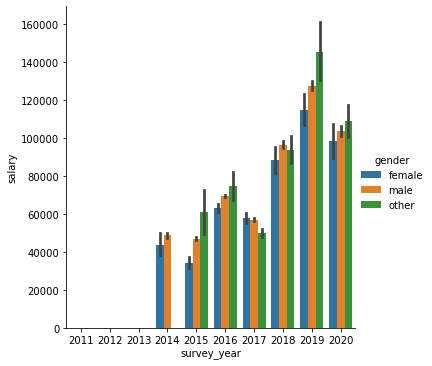

In [15]:
sns.catplot(x="survey_year",       # x variable name
            y="salary",       # y variable name
            hue="gender",  # group variable name
            data=df,     # dataframe to plot
            kind="bar",
            estimator=np.average)

(2014.0, 2020.0)

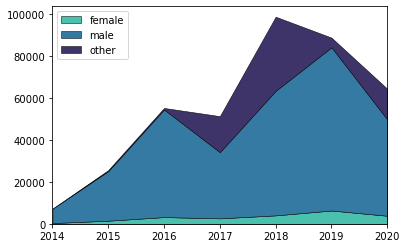

In [16]:
dt = df.groupby(["survey_year", "gender"])
dg = dt['gender'].count().unstack().fillna(0)

fig, ax = plt.subplots()
ax.stackplot(
    dg.index,
    dg.values.T, 
    # baseline='wiggle',
    colors=sns.color_palette("mako_r", 3),
    labels=dg.columns,
    edgecolor='k',
    linewidth=0.5
)
ax.legend(loc=2)
ax.set_xlim(dg.index.min(), dg.index.max())


That's a lot whole lot more people identifying as male in the survey

Finally, save the DataFrame for later analysis

In [17]:
xzsave(df, "surveys.pz")